# Weird Planet Gravity

Specify an arbitrary planet (single connected mass) in 2d and visualise gravity on the surface

Based on [Square Planet Gravity](https://github.com/safetydave/maths-whimsy/blob/main/square_planet_gravity.ipynb) - with further improvements on numpy methods.

Todos:
  - don't calculate gravity at interior points - exclude indexes
  - make the surface normals smoother - interpolated surface curve & interpolated gravity field?



# Define mass distribution

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

Create a banana shaped planet.

Banana image is from Evan Amos under Creative Commons Attribution-Share Alike 3.0 Unported license. Therefore, all derived images are provided under Create Commons Attribution-Share Alike 3.0 Unported license, author David Colls.

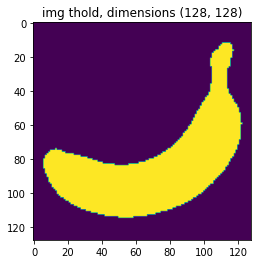

In [2]:
from PIL import Image
import requests

banana_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/8/8a/Banana-Single.jpg/128px-Banana-Single.jpg'
threshold_mass = 230
padding_to_square = ((7, 8), (0, 0))

image = Image.open(requests.get(banana_url, stream=True).raw)
img_data = np.asarray(image.convert('L')) < threshold_mass
img_data = np.pad(img_data, padding_to_square, 'constant', constant_values=False)

plt.imshow(img_data)
plt.title('img thold, dimensions {}'.format(img_data.shape))
plt.show()

Uncomment this to draw your own planet

In [3]:
#img_data = None

Set up space with indexing

In [4]:
# define the region of space
extent = img_data.shape[0] if img_data is not None else 10
centre = extent // 2

# mesh grid of points in space
xn = np.linspace(0, extent, extent)
yn = xn.copy()
xng, yng = np.meshgrid(xn, yn)
png = np.stack((xng.flatten(), yng.flatten()), axis=1)

Helper functions for mass - draw your own planet

In [5]:
def add_square_mass(mass, centre_x, centre_y, delta):
  mass[centre_x - delta:centre_x + delta,
       centre_y - delta:centre_y + delta] = 1.0

def add_round_mass(mass, centre_x, centre_y, delta):
  rng = np.hypot(xng - centre_x, yng - centre_y)
  ids = np.nonzero(rng < delta)
  mass[ids] = 1.0

Define the mass distribution - draw your own planet

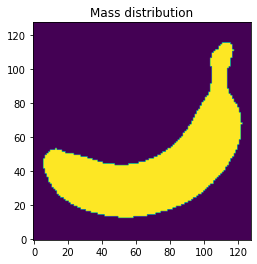

In [6]:
if img_data is None:
  # mass
  mass = np.zeros((extent, extent))

  # define a planet
  planet = 4
  #add_round_mass(mass, centre, centre, planet)
  add_square_mass(mass, centre, centre, planet // 2)
  #add_square_mass(mass, centre, centre - planet // 2, planet // 2)
  #add_square_mass(mass, centre, centre + planet // 2, planet // 2)
  #add_square_mass(mass, centre - planet // 2, centre, planet // 2)
  #add_square_mass(mass, centre + planet // 2, centre, planet // 2)

else:
  mass = np.flip(img_data.astype(int), 0)


plt.imshow(mass, origin='lower')
plt.title('Mass distribution')
plt.show()

# Determine a curve that follows the surface

Find the next cell forward, and to the side, given a direction, for determining contact with mass

In [7]:
def forward(i, j, dir):
  sign = 1 if dir >= 2 else -1
  di = (dir % 2 == 0) * sign
  dj = (dir % 2 == 1) * -sign
  return i + di, j + dj

def contact(i, j, dir):
  return forward(i, j, (dir + 3) % 4)

Follow the surface of the mass (LH/RH maze algorithm). Todo - tidy this up a bit as a method

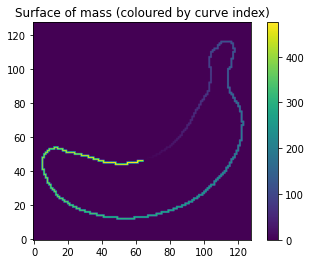

In [8]:
# find min centre
i0 = extent
j0 = centre
while mass[i0 - 1, j0] == 0:
  i0 = i0 - 1

# start surface curve
sc = ([i0], [j0])

# set direction & first point
dir = 1
i = i0
j = j0 + 1
sc[0].append(i)
sc[1].append(j)

# trace edge of mass with right-hand maze following
while not (i == i0 and j == j0):
  check_contact = contact(i, j, dir)
  if mass[check_contact[0], check_contact[1]] == 0:
    dir = (dir + 3) % 4
  check_forward = forward(i, j, dir)
  while mass[check_forward[0], check_forward[1]] != 0:
    dir = (dir + 1) % 4
    check_forward = forward(i, j, dir)
  sc[0].append(check_forward[0])
  sc[1].append(check_forward[1])
  i = check_forward[0]
  j = check_forward[1]

# visualise surface curve
sc_seq = np.linspace(0, len(sc[0]), len(sc[0]))
surf = np.zeros((extent, extent))
surf[sc] = sc_seq

plt.imshow(surf, origin='lower')
plt.title('Surface of mass (coloured by curve index)')
plt.colorbar()
plt.show()

# Calculate gravity

All points in this indexed region that have mass (currently assumed unit mass - todo repeated points could increase density)

In [9]:
pmg = np.argwhere(mass > 0)
pmg.shape

(4319, 2)

Meshgrid for all indexed points in space to feel all points with mass

In [10]:
mi = np.arange(len(pmg))
nj = np.arange(len(png))
mig, njg = np.meshgrid(mi, nj)
pmg[mig].shape, png[njg].shape

((16384, 4319, 2), (16384, 4319, 2))

Contribution to gravitational field from at a point from a mass - need to move mass to centre of cell

In [11]:
def dgrav(pm, pn):
  d = pm + [0.5, 0.5] - pn
  r = np.hypot(d[:,:,0], d[:,:,1])
  return d / np.power(r, 3).reshape(png.shape[0], pmg.shape[0], 1)

Gravitational field regional calculation

In [12]:
G = np.apply_along_axis(sum, 1, dgrav(pmg[mig], png[njg]))

Resultant field outside of masses

In [13]:
G_grid = G.reshape((extent, extent, 2), order='F')
G_grid[np.nonzero(mass)] = 0

# Visualise field in space and on surface

Visualise field strength in space and along surface

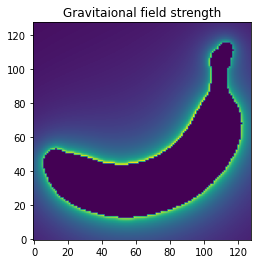

In [14]:
field_strength = np.hypot(G_grid[:,:,1], G_grid[:,:,0])
plt.imshow(field_strength, origin='lower')
plt.title('Gravitaional field strength')
plt.show()

A smoothing factor, and wrapping moving averages, to use depending on whether we're visualising a body with sharp corners (like a square, as per the original) or trying to compensate for the aliasing that occurs with an arbitrary body, like a banana.

Set smoothing factor to 1 for squares, higher (eg 11), for bananas. 

In [15]:
smoothing_factor = 11

def moving_average(a, n=3):
  ret = np.cumsum(a, dtype=float)
  ret[n:] = ret[n:] - ret[:-n]
  return ret[n - 1:] / n

def wrap_moving_average(a, n=3):
  return moving_average(np.pad(a, n // 2, mode='wrap'), n)

Visualise field strength on the surface

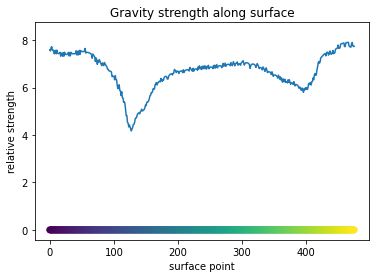

In [16]:
f = field_strength[sc]

f_smooth = wrap_moving_average(f, n=smoothing_factor)

plt.plot(sc_seq, f_smooth)
plt.scatter(sc_seq, np.zeros(sc_seq.shape[0]), c=sc_seq)
plt.title('Gravity strength along surface')
plt.xlabel('surface point')
plt.ylabel('relative strength')
plt.ylim((0 - max(f) * 0.05, max(f) * 1.05))
plt.show()

Visualise field direction in space and along surface

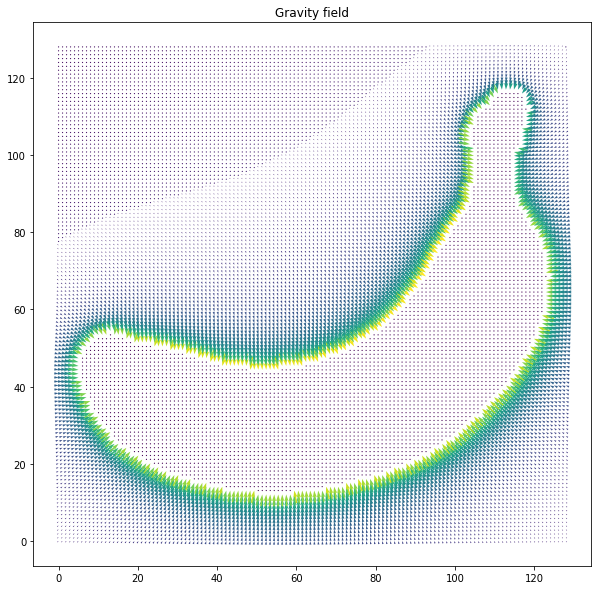

In [17]:
G_lin = G_grid.reshape((extent * extent, 2))

colours = np.hypot(G_lin[:,0], G_lin[:,1])
plt.figure(figsize=(10, 10))
plt.quiver(xng, yng, G_lin[:,1], G_lin[:,0], colours, pivot='tip')
plt.title('Gravity field')
plt.show()

Calculate the surface normal, with some degree of smoothing

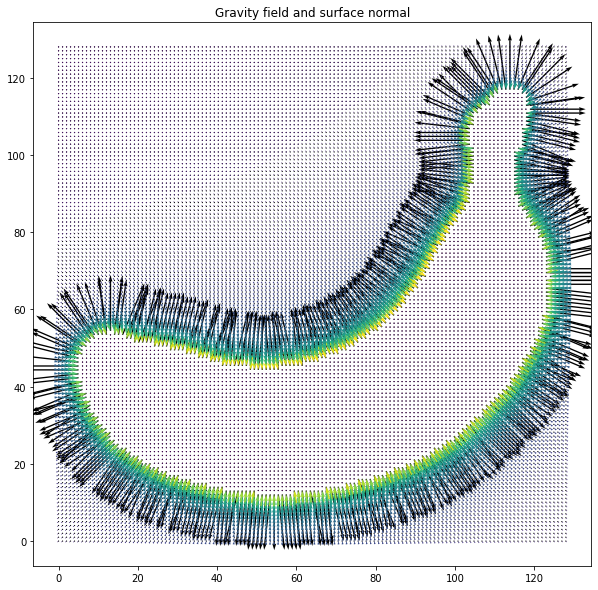

In [18]:
def normal_from_segment(curve_prev, curve_next):
  curve_dir = curve_next - curve_prev
  segment_len = np.hypot(curve_dir[0,:], curve_dir[1,:])
  curve_tan = curve_dir / segment_len
  return np.array((-curve_tan[1,:], curve_tan[0,:]))

sn_smooth_step = max(1, smoothing_factor // 2)
sc_prev = np.roll(sc, -sn_smooth_step, 1)
sc_next = np.roll(sc, sn_smooth_step, 1)
sc_norm = normal_from_segment(sc_prev, sc_next)

N_grid = np.zeros((extent, extent, 2))
N_grid[sc] = sc_norm.T
N_lin = N_grid.reshape((extent * extent), 2)

plt.figure(figsize=(10, 10))
plt.quiver(xng, yng, N_lin[:,1], N_lin[:,0], pivot='tail', scale=10)
plt.quiver(xng, yng, G_lin[:,1], G_lin[:,0], colours, pivot='tip')
plt.title("Gravity field and surface normal")
plt.show()

Calculate the deviation or angle between gravity vector and surface normal at each point

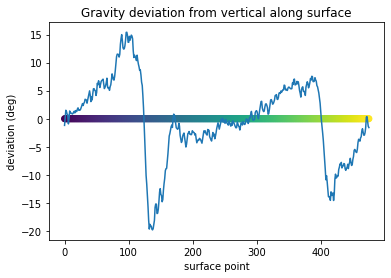

In [19]:
G_sc = G_grid[sc].T
G_sc_n = G_sc / f

# is there an easier way to do this??
def inner_product(A, B):
  return A[0,:] * B[0,:] + A[1,:] * B[1,:]

def cross_product(A, B):
  return A[0,:] * B[1,:] - A[1,:] * B[0,:]

inner_prod = inner_product(-G_sc_n, sc_norm) 
sign_x_prod = np.sign(cross_product(G_sc_n, sc_norm))
angle_vert = 180 / math.pi * np.arccos(inner_prod) * sign_x_prod
angle_vert_smooth = wrap_moving_average(angle_vert, n=smoothing_factor)

plt.plot(sc_seq, angle_vert_smooth)
plt.scatter(sc_seq, np.zeros(sc_seq.shape[0]), c=sc_seq)
plt.title('Gravity deviation from vertical along surface')
plt.xlabel('surface point')
plt.ylabel('deviation (deg)')
plt.show()

Visualise gravity deviation with vectors

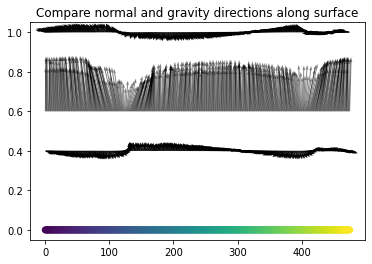

In [20]:
slope_cos = np.cos(angle_vert_smooth * math.pi / 180)
slope_sin = np.sin(angle_vert_smooth * math.pi / 180)

plt.quiver(sc_seq, np.ones(sc_seq.shape[0]) * 0.4, sc_norm[0,:], sc_norm[1,:], pivot='tail')
plt.quiver(sc_seq, np.ones(sc_seq.shape[0]), G_sc[0,:], G_sc[1,:], pivot='tail')
plt.quiver(sc_seq, np.ones(sc_seq.shape[0]) * 0.6, -slope_sin * f, slope_cos * f, pivot='tail', scale=50, alpha=0.5)
plt.scatter(sc_seq, np.zeros(sc_seq.shape[0]), c=sc_seq)
plt.title('Compare normal and gravity directions along surface')
plt.show()

# Produce a summary visual

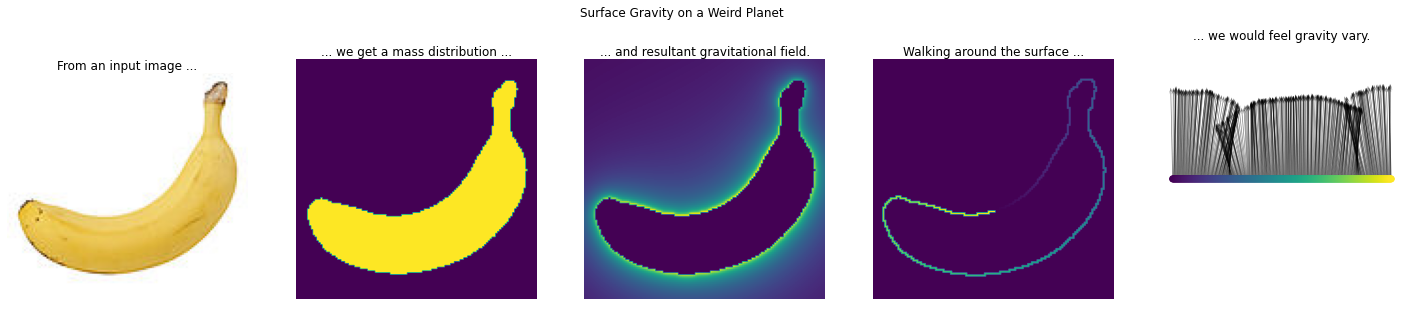

In [24]:
fig, ax = plt.subplots(1, 5)
fig.set_figwidth(25)
fig.set_figheight(5)

if img_data is not None:
  ax[0].imshow(image)
ax[0].axis('off')
ax[0].set_title('From an input image ...')
ax[1].imshow(mass, origin='lower')
ax[1].axis('off')
ax[1].set_title('... we get a mass distribution ...')
ax[2].imshow(field_strength, origin='lower')
ax[2].axis('off')
ax[2].set_title('... and resultant gravitational field.')
ax[3].imshow(surf, origin='lower')
ax[3].axis('off')
ax[3].set_title('Walking around the surface ...')
ax[4].quiver(sc_seq,
             np.zeros(sc_seq.shape[0]),
             slope_sin * f_smooth,
             slope_cos * f_smooth,
             pivot='tail',
             scale=20,
             alpha=0.5,
             headwidth=6,
             headlength=10)
ax[4].scatter(sc_seq, np.zeros(sc_seq.shape[0]), c=sc_seq)
ax[4].axis('off')
plt.rcParams['axes.titlepad'] = -140
ax[4].set_title('... we would feel gravity vary.')

fig.suptitle('Surface Gravity on a Weird Planet')

plt.show()

# Unused edge detection techniques

May be useful in other scenarios...

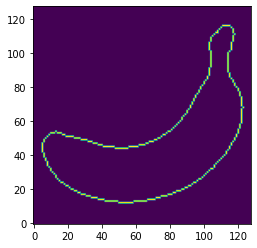

In [22]:
# edge detection binary 4-way

mass_left = np.roll(mass, 1, 0)
mass_right = np.roll(mass, -1, 0)
mass_up = np.roll(mass, 1, 1)
mass_down = np.roll(mass, -1, 1)
surf2 = ((mass_left - mass) > 0) | ((mass_right - mass) > 0) | ((mass_up - mass) > 0) | ((mass_down - mass) > 0)
plt.imshow(surf2, origin='lower')
plt.show()

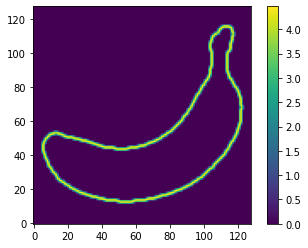

In [23]:
# generic edge detect

from scipy import ndimage

sx = ndimage.sobel(mass, axis=0, mode='constant')
sy = ndimage.sobel(mass, axis=1, mode='constant')
sob = np.hypot(sx, sy)
plt.imshow(sob, origin='lower')
plt.colorbar()
plt.show()